In [1]:
%matplotlib inline
# %matplotlib widget # for interactive figures

In [2]:
import matplotlib.pyplot as plt
import xtrack as xt
import numpy as np

## Import MAD-X sequence to Xsuite

In [3]:
env = xt.load(["../../xtrack/test_data/ps_sftpro/ps.seq",
               "../../xtrack/test_data/ps_sftpro/ps_hs_sftpro.str"])
line = env.ps

In [4]:
line.set_particle_ref('proton', p0c=14e9)

In [5]:
# Choose bend model appropriate for small rings
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=10)

### Match tune

In [6]:
opt = line.match(
    method='4d',
    solve=False,
    vary=[xt.VaryList(['kf', 'kd'], step=1e-5)],
    targets=[xt.TargetSet(qx=6.255278, qy=6.29826, tol=1e-7)],
)
opt.solve()

                                             
Optimize - start penalty: 0.0008618                         
Matching: model call n. 5 penalty = 3.1828e-08              
Optimize - end penalty:  3.18277e-08                            


### Inspect phase space

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, 'px')

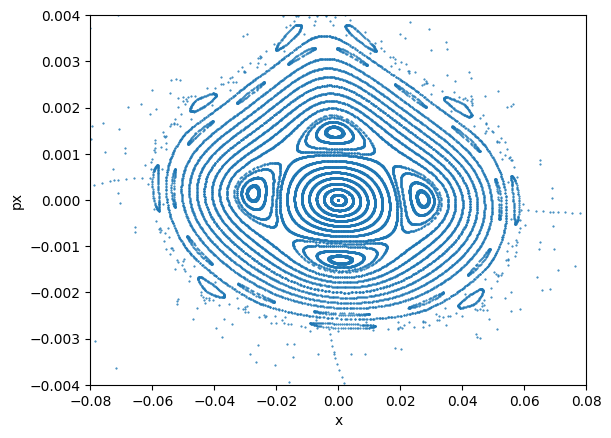

In [7]:
# Generate some particles close on the x axis in normalized phase sepace
r0 = np.linspace(0, 100, 50)
p = line.build_particles(
    method='4d', 
    x_norm=r0*np.cos(np.pi/20.),
    px_norm=0,
    nemitt_x=1e-6, nemitt_y=1e-6)

line.track(p, num_turns=1000, turn_by_turn_monitor=True, with_progress=True)
mon = line.record_last_track

import matplotlib.pyplot as plt
plt.close('all')
plt.figure(1)
plt.plot(mon.x.flatten(), mon.px.flatten(), '.', markersize=1)
plt.ylim(-0.004, 0.004)
plt.xlim(-0.08, 0.08)
plt.xlabel('x')
plt.ylabel('px')

### Standard twiss

In [8]:
tw_core = line.twiss(method='4d')
tw_core.qx, tw_core.qy

(6.255278002260508, 6.2982600022405695)

### Multi-turn twiss

In [9]:
tw_mt = line.twiss(co_guess={'x': 0.025}, num_turns=4, method='4d')
tw_mt.mux[-1], tw_mt.muy[-1]

(24.97418486750196, 25.214403947296503)

### Select rows corresponding to start turns

In [10]:
tw_start_turns = tw_mt.rows['_turn_.*']
tw_start_turns.show()

name                s             x            px             y            py          zeta ...
_turn_0             0     0.0272759   2.82063e-05   3.90029e-24   2.59844e-25   1.90145e-29
_turn_1       628.318   0.000598109   -0.00129796   2.20679e-24  -4.31282e-25    -0.0038111
_turn_2       1256.64    -0.0277017   0.000148129  -5.23495e-24  -3.51485e-26   0.000711737
_turn_3       1884.96    -0.0013618    0.00147611   1.07333e-24   3.72434e-25     0.0047382


### Plot twiss results on top of tracking data

Text(0, 0.5, 'px')

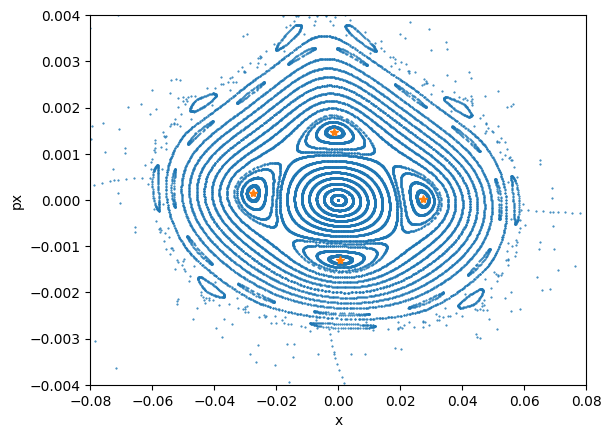

In [11]:
plt.figure()
plt.plot(mon.x.flatten(), mon.px.flatten(), '.', markersize=1)
plt.plot(tw_start_turns.x, tw_start_turns.px, '*')
plt.ylim(-0.004, 0.004)
plt.xlim(-0.08, 0.08)
plt.xlabel('x')
plt.ylabel('px')

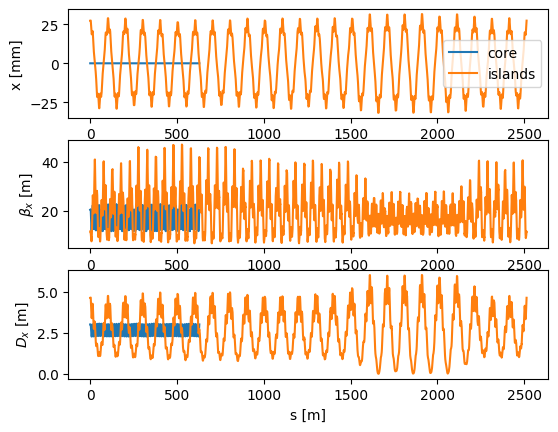

In [12]:
plt.figure()
ax1 = plt.subplot(3,1,1)
plt.plot(tw_core.s, tw_core.x * 1e3, label='core')
plt.plot(tw_mt.s, tw_mt.x * 1e3, label='islands')
plt.legend()
plt.ylabel('x [mm]')
plt.subplot(3,1,2, sharex=ax1)
plt.plot(tw_core.s, tw_core.betx)
plt.plot(tw_mt.s, tw_mt.betx)
plt.ylabel(r'$\beta_x$ [m]')
plt.subplot(3,1,3, sharex=ax1)
plt.plot(tw_core.s, tw_core.dx)
plt.plot(tw_mt.s, tw_mt.dx)
plt.xlabel('s [m]')
plt.ylabel(r'$D_x$ [m]')
plt.subplots_adjust(left=.15)

plt.show()